In [15]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

def load_data(source=None, target_col=None, test_size=0.25, random_state=0):
    """
    通用数据加载函数。
    - source=None: 使用默认合成数据集（sin函数）。
    - source='boston'/'diabetes'/'california': 使用sklearn内置数据集。
    - source为文件路径或DataFrame: 加载其中的数据。
    target_col: 指定哪一列作为标签（针对DataFrame/CSV）。若为None且数据集有明确标签列则自动检测。
    返回: (X_train, y_train, X_pool, y_pool, X_test, y_test)
          其中X_train, y_train为初始有标签集（可为0大小，由控制器再初始化），
          X_pool, y_pool为未标注池，X_test, y_test为测试集。
    """
    # If no source specified, generate a synthetic regression dataset (e.g., sin curve)
    if source is None:
        # Generate synthetic 1D data: y = sin(x) + noise
        rng = np.random.RandomState(random_state)
        X = rng.uniform(0, 10, size=(200, 1))
        y = np.sin(X).ravel() + 0.1 * rng.randn(X.shape[0])
        # Sort by X for easier visualization (optional)
        sort_idx = np.argsort(X[:, 0])
        X, y = X[sort_idx], y[sort_idx]
    elif isinstance(source, str):
        src_lower = source.lower()
        if src_lower in ('boston', 'boston housing'):
            # sklearn.datasets.load_boston (note: may be removed in recent versions)
            data = datasets.load_boston()
            X, y = data.data, data.target
        elif src_lower == 'diabetes':
            data = datasets.load_diabetes()
            X, y = data.data, data.target
        elif src_lower in ('california', 'california housing'):
            data = datasets.fetch_california_housing()
            X, y = data.data, data.target
        else:
            # Assume it's a file path to CSV
            df = pd.read_csv(source)
            # If target_col given use it, otherwise use last column
            if target_col and target_col in df.columns:
                y = df[target_col].values
                X = df.drop(columns=[target_col]).values
            else:
                # use last column as target
                y = df.iloc[:, -1].values
                X = df.iloc[:, :-1].values
    elif isinstance(source, pd.DataFrame):
        df = source.copy()
        if target_col and target_col in df.columns:
            y = df[target_col].values
            X = df.drop(columns=[target_col]).values
        else:
            y = df.iloc[:, -1].values
            X = df.iloc[:, :-1].values
    else:
        raise ValueError("Unsupported data source type")
    # Split into train (initial labeled) = 0 (placeholder, to be set by AL controller), pool (unlabeled), and test
    X_train = np.empty((0, X.shape[1]))
    y_train = np.array([])  # initially no labels, will initialize in AL loop
    # Use train_test_split to get pool vs test
    X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, y_train, X_pool, y_pool, X_test, y_test


In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# XGBoost library (ensure it is installed: pip install xgboost)
try:
    import xgboost as xgb
except ImportError:
    xgb = None

class BaseModel:
    """模型基类，定义接口。其他模型需继承此类并实现train, predict, predict_with_uncertainty。"""
    def train(self, X, y):
        raise NotImplementedError
    def predict(self, X):
        raise NotImplementedError
    def predict_with_uncertainty(self, X):
        """返回(pred_mean, pred_std)"""
        raise NotImplementedError

class GPModel(BaseModel):
    def __init__(self):
        # 核函数: RBF核 + 白噪声核，用于回归
        kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0)  # alpha=0 implies no additional Gaussian noise beyond WhiteKernel
    def train(self, X, y):
        if len(y) == 0:
            return  # no data to train
        self.gp.fit(X, y)
    def predict(self, X):
        return self.gp.predict(X)
    def predict_with_uncertainty(self, X):
        # GaussianProcessRegressor 支持返回不确定性（标准差）
        y_mean, y_std = self.gp.predict(X, return_std=True)
        return y_mean, y_std

class XGBModel(BaseModel):
    def __init__(self, n_models=5, **xgb_params):
        """
        使用多个XGBoost模型的集成来估计不确定性。
        n_models: 使用多少个XGBoost子模型。
        xgb_params: 额外的XGBoost参数，如max_depth, n_estimators（树数量）等。
        """
        if xgb is None:
            raise ImportError("XGBoost library is not installed.")
        self.n_models = n_models
        self.models = []
        # 基础参数：启用子采样和列采样以引入随机性
        default_params = {
            'max_depth': 3,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'use_label_encoder': False,
            'eval_metric': 'rmse'
        }
        default_params.update(xgb_params)
        self.xgb_params = default_params

    def train(self, X, y):
        self.models = []
        if len(y) == 0:
            return
        # 训练n_models个XGBoost模型（可采用不同随机种子）
        for i in range(self.n_models):
            model = xgb.XGBRegressor(**self.xgb_params, random_state=42 + i)
            model.fit(X, y)
            self.models.append(model)

    def predict(self, X):
        if not self.models:
            return None
        # 如果只有一个模型，直接预测；多个模型时取平均预测
        preds = [model.predict(X) for model in self.models]
        preds = np.array(preds)  # shape: (n_models, n_samples)
        if self.n_models == 1:
            return preds[0]
        else:
            return np.mean(preds, axis=0)

    def predict_with_uncertainty(self, X):
        if not self.models:
            return None, None
        preds = [model.predict(X) for model in self.models]
        preds = np.array(preds)  # shape: (n_models, n_samples)
        if self.n_models == 1:
            # 单模型时，没有直接的不确定性；这里返回0标准差
            return preds[0], np.zeros_like(preds[0])
        # 计算均值和标准差
        mean_pred = np.mean(preds, axis=0)
        std_pred = np.std(preds, axis=0)
        return mean_pred, std_pred

# 提示：未来可以扩展更多模型，如：
# class FFXModel(BaseModel): ... （利用FFX算法训练一个符号回归模型）
# class GPProgramModel(BaseModel): ... （遗传规划符号回归模型，可能需要实现自己的预测和不确定性估计）


In [17]:
from sklearn.cluster import KMeans

class StrategyBase:
    """策略基类，定义select接口。"""
    def select(self, model: BaseModel, X_pool: np.ndarray, y_pool: np.ndarray, batch_size: int):
        raise NotImplementedError

class UncertaintySampling(StrategyBase):
    def select(self, model: BaseModel, X_pool, y_pool, batch_size=1):
        # 使用模型的不确定性（预测标准差）来选取
        if X_pool.shape[0] == 0:
            return []
        # 获取预测均值和不确定度
        _, std = model.predict_with_uncertainty(X_pool)
        # 选取不确定性最大的样本索引
        # argsort返回从小到大的索引，[-batch_size:]取最大的batch_size个索引
        idx = np.argsort(std)
        selected_indices = idx[-batch_size:][::-1]  # 按降序排列索引
        return selected_indices.tolist()

class UncertaintyDensitySampling(StrategyBase):
    def __init__(self, k_neighbors=5):
        """
        k_neighbors: 用于计算密度时考虑的近邻数量。
        密度分数定义为该样本到最近k_neighbors个未标注样本的平均距离的倒数。
        """
        self.k = k_neighbors

    def _compute_density_scores(self, X_pool):
        # 计算每个点与X_pool其他点的平均距离（基于k个最近邻）
        N = X_pool.shape[0]
        if N == 0:
            return np.array([])
        # 距离矩阵（可以优化，但N一般不大时可直接计算）
        # 使用欧氏距离
        dists = np.linalg.norm(X_pool[:, np.newaxis, :] - X_pool[np.newaxis, :, :], axis=2)
        # 对每行排序并取1到k+1项（跳过自身0距离）
        # numpy中将自身距离设为大值以方便取最近邻
        np.fill_diagonal(dists, np.inf)
        # 对每个样本，找到k个最近邻距离
        k = min(self.k, N - 1)  # 当未标注样本数量小于k时调整
        nearest_dists = np.partition(dists, kth=k, axis=1)[:, :k]
        # 计算平均距离并取倒数作为密度（距离小->密度高）
        avg_dists = nearest_dists.mean(axis=1)
        density_scores = 1.0 / (avg_dists + 1e-8)
        # 正规化密度分数到0-1区间
        density_scores = (density_scores - density_scores.min()) / (density_scores.max() - density_scores.min() + 1e-8)
        return density_scores

    def select(self, model: BaseModel, X_pool, y_pool, batch_size=1):
        if X_pool.shape[0] == 0:
            return []
        # 获取不确定性评分
        _, std = model.predict_with_uncertainty(X_pool)
        # 计算密度评分
        density_scores = self._compute_density_scores(X_pool)
        # 归一化不确定性分数
        uncert_scores = (std - std.min()) / (std.max() - std.min() + 1e-8)
        # 组合评分 = 不确定性 * 密度
        combined_scores = uncert_scores * density_scores
        # 选取组合评分最高的 batch_size 个样本
        idx = np.argsort(combined_scores)
        selected_indices = idx[-batch_size:][::-1]
        return selected_indices.tolist()

class DiversitySampling(StrategyBase):
    def __init__(self, mode='farthest'):
        """
        mode: 'farthest' 或 'cluster' 两种模式。
        - 'farthest': 每次选择距离已标注集最远的点（若batch_size>1，则迭代选择多次）。
        - 'cluster': 使用KMeans聚类选点。
        """
        assert mode in ('farthest', 'cluster')
        self.mode = mode

    def select(self, model, X_pool, y_pool, batch_size=1):
        n_pool = X_pool.shape[0]
        if n_pool == 0 or batch_size <= 0:
            return []
        batch_size = min(batch_size, n_pool)  # 批量不得超过池大小
        if self.mode == 'farthest':
            selected_idx = []
            # 计算每个pool点到最近的已选点或已标注点的距离。
            # 这里已标注点的信息需要从model或外部获取。但在此策略中，没有直接已标注集传入。
            # 我们假设调用此策略时，只在初始回合使用random或其他策略开启；此策略主要用于batch内部。
            # 为简单起见，这里退而求其次：选择pool中两两之间尽可能远的点作为替代（即从pool自身出发选择远离彼此的点）。
            # 先随机选择一个起点，然后迭代选择距离当前已选集最远的点。
            if batch_size == 1:
                # 如果batch=1，简单选择距池中平均点最远的点
                center = np.mean(X_pool, axis=0)
                dists = np.linalg.norm(X_pool - center, axis=1)
                idx = np.argmax(dists)
                return [int(idx)]
            # 批量: 迭代选出batch_size个点
            # 1. 随机选择第一个点或选中心最远点
            center = np.mean(X_pool, axis=0)
            first_idx = int(np.argmax(np.linalg.norm(X_pool - center, axis=1)))
            selected_idx.append(first_idx)
            # 2. 循环选择其余点
            # 维护每个未选点到已选集合的最近距离
            dist_to_selected = np.linalg.norm(X_pool - X_pool[first_idx], axis=1)
            for _ in range(batch_size - 1):
                # 当前未选点中距离集合最远者
                for j in selected_idx:
                    dist_to_selected[j] = 0  # 已选点本身不再考虑
                next_idx = int(np.argmax(dist_to_selected))
                selected_idx.append(next_idx)
                # 更新每个未选点距已选集合的最近距离
                new_dists = np.linalg.norm(X_pool - X_pool[next_idx], axis=1)
                dist_to_selected = np.minimum(dist_to_selected, new_dists)
            return selected_idx
        elif self.mode == 'cluster':
            # 使用KMeans将未标注池聚为batch_size个簇，然后选每个簇中心最近的点
            k = min(batch_size, n_pool)
            kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
            labels = kmeans.fit_predict(X_pool)
            centers = kmeans.cluster_centers_
            selected_idx = []
            # 对每个簇，找到离中心最近的点索引
            for i in range(k):
                cluster_idx = np.where(labels == i)[0]
                center = centers[i]
                # 计算簇内各点到中心距离
                dists = np.linalg.norm(X_pool[cluster_idx] - center, axis=1)
                # 选距离最小的那个
                rep = cluster_idx[np.argmin(dists)]
                selected_idx.append(int(rep))
            return selected_idx

class HybridSampling(StrategyBase):
    def __init__(self, candidacy_factor=5):
        """
        candidacy_factor: 候选集大小是batch_size的倍数。
        我们会先根据不确定性×密度选出 candidacy_factor*batch_size 个候选样本，再通过多样性筛选最终的batch_size个。
        """
        self.candidacy_factor = candidacy_factor
        # 我们内部复用前面定义的策略
        self.uncert_density = UncertaintyDensitySampling()
        self.diversity = DiversitySampling(mode='cluster')

    def select(self, model, X_pool, y_pool, batch_size=1):
        n_pool = X_pool.shape[0]
        if n_pool == 0:
            return []
        batch_size = min(batch_size, n_pool)
        # 若batch为1，直接等同于不确定性×密度策略
        if batch_size == 1:
            return self.uncert_density.select(model, X_pool, y_pool, batch_size=1)
        # 计算候选集合大小
        M = min(n_pool, batch_size * self.candidacy_factor)
        if M < batch_size:
            # 不足batch_size个样本的情形，直接全部返回
            return list(range(n_pool))
        # 1. 不确定性×密度 得分排序，取前M个候选
        _, std = model.predict_with_uncertainty(X_pool)
        density_scores = self.uncert_density._compute_density_scores(X_pool)
        uncert_scores = (std - std.min()) / (std.max() - std.min() + 1e-8)
        combined = uncert_scores * density_scores
        candidate_idx = np.argsort(combined)[-M:]
        candidate_X = X_pool[candidate_idx]
        # 2. 在候选中应用多样性（聚类）选出batch_size个
        if batch_size >= candidate_X.shape[0]:
            selected_candidates = candidate_idx.tolist()
        else:
            # 聚簇选点
            kmeans = KMeans(n_clusters=batch_size, random_state=0, n_init='auto')
            labels = kmeans.fit_predict(candidate_X)
            centers = kmeans.cluster_centers_
            selected_candidates = []
            for i in range(batch_size):
                cluster_idx = np.where(labels == i)[0]
                center = centers[i]
                dists = np.linalg.norm(candidate_X[cluster_idx] - center, axis=1)
                rep_local = cluster_idx[np.argmin(dists)]
                rep_idx = candidate_idx[rep_local]  # 转换为原pool索引
                selected_candidates.append(int(rep_idx))
        return selected_candidates


In [18]:
class ActiveLearningController:
    def __init__(self, model: BaseModel, strategy: StrategyBase, batch_size:int=1):
        """
        初始化主动学习控制器。
        model: 使用的模型 (需实现BaseModel接口)
        strategy: 选择样本的策略 (需实现StrategyBase接口)
        batch_size: 每轮选取的样本数
        """
        self.model = model
        self.strategy = strategy
        self.batch_size = batch_size
        # 数据集在run时传入，此处仅占位
        self.X_train = None
        self.y_train = None
        self.X_pool = None
        self.y_pool = None
        # 记录学习曲线（已标注数量 vs RMSE）
        self.history = []

    def initialize_data(self, X_train, y_train, X_pool, y_pool):
        """设置初始已标注数据和未标注池。"""
        self.X_train = X_train.copy()
        self.y_train = y_train.copy()
        self.X_pool = X_pool.copy()
        self.y_pool = y_pool.copy()

    def run(self, n_iterations:int=None, n_total:int=None, X_test=None, y_test=None):
        """
        运行主动学习循环。
        n_iterations: 迭代轮数（None则依据n_total）
        n_total: 期望总标注样本数（包含初始已标注），如果提供则忽略n_iterations。
        X_test, y_test: 可选的测试集用于评估RMSE。
        返回: history (list of (labeled_count, RMSE)) 每轮训练后记录的指标。
        """
        if self.X_pool is None or self.X_train is None:
            raise RuntimeError("Data not initialized. Call initialize_data first.")
        # 推算循环次数
        if n_total is not None:
            # 总共想要标注的数量
            target_total = min(n_total, self.X_pool.shape[0] + self.X_train.shape[0])
            # 计算所需迭代轮次
            current_total = self.X_train.shape[0]
            if self.batch_size > 0:
                n_iterations = int(np.ceil((target_total - current_total) / self.batch_size))
            else:
                n_iterations = 0
        elif n_iterations is None:
            raise ValueError("Either n_iterations or n_total must be provided")
        # 主循环
        for it in range(int(n_iterations)):
            # 1. 训练模型
            self.model.train(self.X_train, self.y_train)
            # 2. 策略选点
            selected_idx = self.strategy.select(self.model, self.X_pool, self.y_pool, batch_size=self.batch_size)
            if len(selected_idx) == 0:
                break  # 无可选样本
            # 3. Oracle提供标签（从y_pool取出真值）
            new_X = self.X_pool[selected_idx]
            new_y = self.y_pool[selected_idx]
            # 4. 加入训练集
            if self.X_train.size == 0:
                # X_train目前是空，通过np.vstack直接赋值会出错，这里特殊处理
                self.X_train = new_X
                self.y_train = new_y
            else:
                self.X_train = np.vstack([self.X_train, new_X])
                self.y_train = np.concatenate([self.y_train, new_y])
            # 从未标注池移除已选样本
            # 为避免索引变动，先将选中的索引排序（降序），再逐个删除
            remove_idx = sorted(selected_idx, reverse=True)
            for idx in remove_idx:
                self.X_pool = np.delete(self.X_pool, idx, axis=0)
                self.y_pool = np.delete(self.y_pool, idx, axis=0)
            # 5. 评估当前模型（计算RMSE）
            rmse_val = None
            if X_test is not None and y_test is not None:
                y_pred = self.model.predict(X_test)
                rmse_val = np.sqrt(np.mean((y_test - y_pred)**2))
            # 记录history
            labeled_count = self.X_train.shape[0]
            if rmse_val is not None:
                self.history.append((labeled_count, rmse_val))
            else:
                self.history.append((labeled_count, None))
            # 可选：打印每轮信息
            print(f"Iteration {it+1}: Labeled {len(selected_idx)} samples, Total labeled = {labeled_count}, RMSE = {rmse_val:.4f}" if rmse_val is not None else "")
            # 若达到目标标注数，则提前结束
            if n_total is not None and labeled_count >= target_total:
                break
        # 循环结束后，做一次最终模型训练（保证模型包含最后一轮新增的数据）
        self.model.train(self.X_train, self.y_train)
        return self.history


In [19]:
import matplotlib.pyplot as plt

def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def plot_learning_curve(history):
    """
    绘制学习曲线：X轴为标注样本数量，Y轴为RMSE。
    history: 列表[(labeled_count, rmse), ...]。
    """
    counts = [h[0] for h in history]
    rmses = [h[1] for h in history]
    plt.figure()
    plt.plot(counts, rmses, marker='o')
    plt.title("Learning Curve (Active Learning)")
    plt.xlabel("Number of labeled samples")
    plt.ylabel("RMSE on test set")
    plt.grid(True)
    plt.show()

def plot_regression_uncertainty(model, X_all, y_all, X_train, y_train):
    """
    针对一维输入的回归问题，绘制模型预测曲线及不确定性带，并标注训练样本的位置。
    model: 训练后的模型
    X_all, y_all: 原始完整数据（用于绘制真值曲线或散点）
    X_train, y_train: 已标注训练数据点
    """
    plt.figure()
    # 如果是一维输入:
    if X_all.shape[1] == 1:
        # 按X排序
        idx = np.argsort(X_all[:, 0])
        X_plot = X_all[idx]
        y_true = y_all[idx]
        # 模型预测均值和不确定性
        y_pred, y_std = model.predict_with_uncertainty(X_plot)
        # 绘制真值函数 (若我们有ground truth函数的话，这里用所有数据点连线表示)
        plt.plot(X_plot, y_true, 'g--', label="True function")
        # 绘制模型预测均值
        plt.plot(X_plot, y_pred, 'b-', label="Predicted mean")
        # 绘制不确定性区域（±1标准差）
        y_pred = np.array(y_pred)
        y_std = np.array(y_std)
        plt.fill_between(X_plot.ravel(),
                         y_pred - y_std, y_pred + y_std,
                         color='b', alpha=0.2, label="Uncertainty (±1 σ)")
    else:
        # 多维输入情况下，我们只能绘制真实y与预测y的散点图或其他替代方案
        y_pred = model.predict(X_all)
        plt.scatter(y_pred, y_all, alpha=0.5, label="Prediction vs True")
        plt.xlabel("Predicted")
        plt.ylabel("True")
    # 绘制训练集点
    plt.scatter(X_train[:,0], y_train, c='r', marker='x', label="Labeled samples")
    plt.title("Model Prediction and Uncertainty")
    plt.legend()
    plt.show()

def plot_sample_distribution(X_train, X_pool):
    """
    绘制样本分布图。
    一维数据：在x轴上标出已标注和未标注样本的位置。
    二维数据：绘制二维平面散点（如数据维度更高，可选择前两维或降维）。
    """
    plt.figure()
    if X_train.shape[1] == 1:
        # 1D: 用y=0的轴线表示，标出x位置
        plt.hlines(0, X_train.min(), X_train.max(), colors='lightgray')  # baseline
        plt.scatter(X_pool, np.zeros_like(X_pool), marker='o', color='gray', alpha=0.5, label="Unlabeled pool")
        plt.scatter(X_train, np.zeros_like(X_train), marker='x', color='red', label="Labeled")
        plt.xlabel("Feature value")
        plt.yticks([])  # 不需要y轴刻度
    else:
        # 取前两维绘制散点
        if X_train.shape[1] > 1:
            plt.scatter(X_pool[:, 0], X_pool[:, 1], color='gray', alpha=0.5, label="Unlabeled pool")
            plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', color='red', label="Labeled")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
        else:
            # fallback: one-dimensional but treated above, so should not be here.
            plt.scatter(X_pool, np.zeros_like(X_pool), color='gray', alpha=0.5, label="Unlabeled pool")
            plt.scatter(X_train, np.zeros_like(X_train), marker='x', color='red', label="Labeled")
    plt.title("Sample Distribution: Labeled vs Unlabeled")
    plt.legend()
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:

Iteration 1: Labeled 1 samples, Total labeled = 6, RMSE = 0.4647
Iteration 2: Labeled 1 samples, Total labeled = 7, RMSE = 0.4786
Iteration 3: Labeled 1 samples, Total labeled = 8, RMSE = 0.2286
Iteration 4: Labeled 1 samples, Total labeled = 9, RMSE = 0.1309
Iteration 5: Labeled 1 samples, Total labeled = 10, RMSE = 0.1301
Iteration 6: Labeled 1 samples, Total labeled = 11, RMSE = 0.1477
Iteration 7: Labeled 1 samples, Total labeled = 12, RMSE = 0.1594
Iteration 8: Labeled 1 samples, Total labeled = 13, RMSE = 0.1638
Iteration 9: Labeled 1 samples, Total labeled = 14, RMSE = 0.1521
Iteration 10: Labeled 1 samples, Total labeled = 15, RMSE = 0.1533
Iteration 11: Labeled 1 samples, Total labeled = 16, RMSE = 0.6001
Iteration 12: Labeled 1 samples, Total labeled = 17, RMSE = 0.6002
Iteration 13: Labeled 1 samples, Total labeled = 18, RMSE = 0.6014
Iteration 14: Labeled 1 samples, Total labeled = 19, RMSE = 0.1480
Iteration 15: Labeled 1 samples, Total labeled = 20, RMSE = 0.1415
Iteratio

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 1: Labeled 5 samples, Total labeled = 10, RMSE = 0.4647
Iteration 2: Labeled 5 samples, Total labeled = 15, RMSE = 0.1820
Iteration 3: Labeled 5 samples, Total labeled = 20, RMSE = 0.1229
Iteration 4: Labeled 5 samples, Total labeled = 25, RMSE = 0.1129
Iteration 5: Labeled 5 samples, Total labeled = 30, RMSE = 0.1072
Final RMSE (Hybrid Strategy): 0.10716256134424941


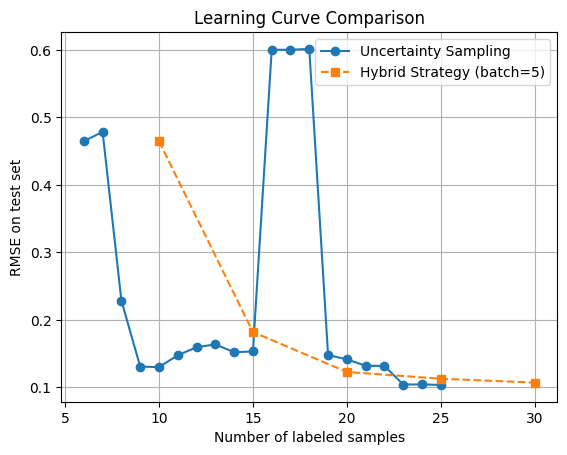

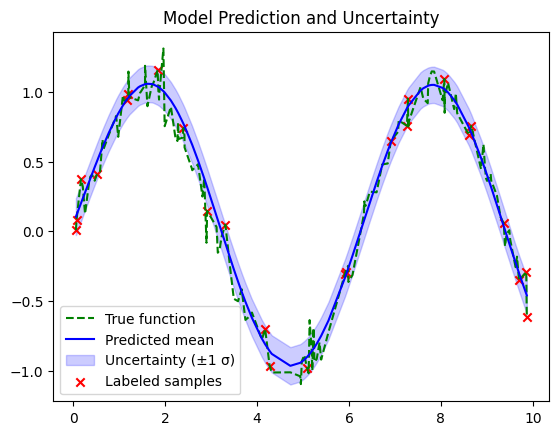

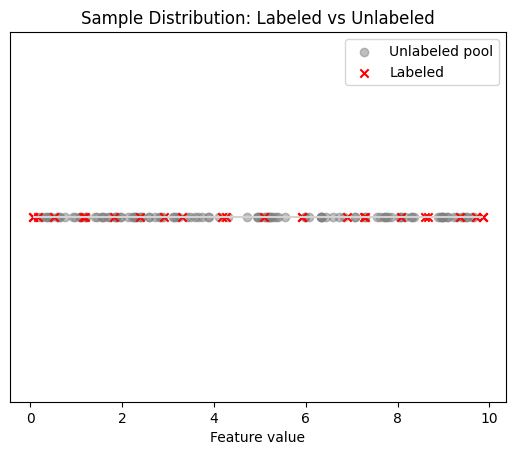

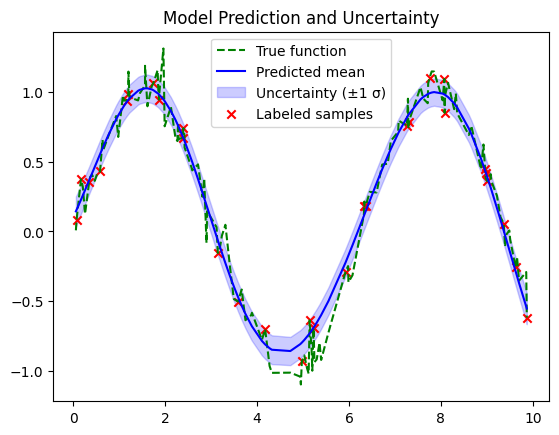

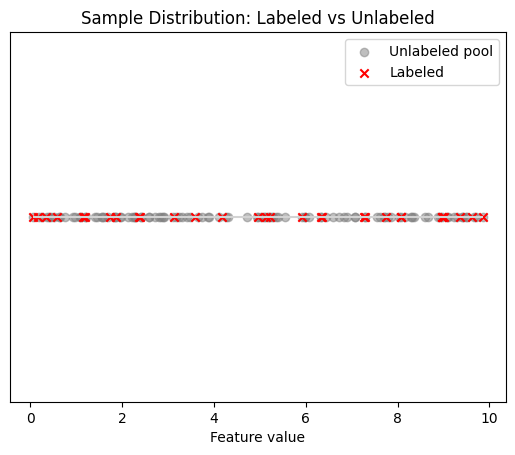

In [20]:
# 准备数据集（使用合成sin函数数据）
X_train, y_train, X_pool, y_pool, X_test, y_test = load_data(source=None, test_size=0.3, random_state=42)

# 初始化模型与策略
model = GPModel()  # 使用高斯过程模型
# 尝试不同策略
strategy_uncert = UncertaintySampling()
strategy_hybrid = HybridSampling(candidacy_factor=5)

# 初始标注一些样本（例如5个）以启动
init_size = 5
# 从未标注池随机挑选init_size个初始点
init_indices = np.random.choice(np.arange(X_pool.shape[0]), size=init_size, replace=False)
X_init = X_pool[init_indices]
y_init = y_pool[init_indices]
# 从池中去除初始点
X_pool_remaining = np.delete(X_pool, init_indices, axis=0)
y_pool_remaining = np.delete(y_pool, init_indices, axis=0)

# 设置并运行主动学习 - 策略1: 纯不确定性采样
al_controller1 = ActiveLearningController(model=GPModel(), strategy=strategy_uncert, batch_size=1)
al_controller1.initialize_data(X_init, y_init, X_pool_remaining, y_pool_remaining)
history1 = al_controller1.run(n_iterations=20, X_test=X_test, y_test=y_test)
print("Final RMSE (Uncertainty Sampling):", history1[-1][1])

# 策略2: 混合策略 (不确定性×密度 + 多样性)
al_controller2 = ActiveLearningController(model=GPModel(), strategy=strategy_hybrid, batch_size=5)
al_controller2.initialize_data(X_init, y_init, X_pool_remaining, y_pool_remaining)
# 例如执行5轮，每轮选5个点（总共再标注25点）
history2 = al_controller2.run(n_iterations=5, X_test=X_test, y_test=y_test)
print("Final RMSE (Hybrid Strategy):", history2[-1][1])

# 绘制学习曲线对比
plt.figure()
plt.plot([h[0] for h in history1], [h[1] for h in history1], 'o-', label="Uncertainty Sampling")
plt.plot([h[0] for h in history2], [h[1] for h in history2], 's--', label="Hybrid Strategy (batch=5)")
plt.xlabel("Number of labeled samples")
plt.ylabel("RMSE on test set")
plt.title("Learning Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

# 可视化最终模型预测与不确定性
# 对于策略1结果：
model_trained1 = al_controller1.model
X_all = np.vstack([al_controller1.X_train, al_controller1.X_pool])  # 所有点
y_all = np.concatenate([al_controller1.y_train, al_controller1.y_pool])
plot_regression_uncertainty(model_trained1, X_all, y_all, al_controller1.X_train, al_controller1.y_train)
plot_sample_distribution(al_controller1.X_train, al_controller1.X_pool)

# 对于策略2结果：
model_trained2 = al_controller2.model
X_all2 = np.vstack([al_controller2.X_train, al_controller2.X_pool])
y_all2 = np.concatenate([al_controller2.y_train, al_controller2.y_pool])
plot_regression_uncertainty(model_trained2, X_all2, y_all2, al_controller2.X_train, al_controller2.y_train)
plot_sample_distribution(al_controller2.X_train, al_controller2.X_pool)


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:

Iteration 1: Labeled 1 samples, Total labeled = 6, RMSE = 0.2375, R2 = 0.8433
Iteration 2: Labeled 1 samples, Total labeled = 7, RMSE = 0.1899, R2 = 0.8998
Iteration 3: Labeled 1 samples, Total labeled = 8, RMSE = 0.2164, R2 = 0.8700
Iteration 4: Labeled 1 samples, Total labeled = 9, RMSE = 0.1450, R2 = 0.9416
Iteration 5: Labeled 1 samples, Total labeled = 10, RMSE = 0.1184, R2 = 0.9611
Iteration 6: Labeled 1 samples, Total labeled = 11, RMSE = 0.1195, R2 = 0.9603
Iteration 7: Labeled 1 samples, Total labeled = 12, RMSE = 0.1176, R2 = 0.9616
Iteration 8: Labeled 1 samples, Total labeled = 13, RMSE = 0.1187, R2 = 0.9609
Iteration 9: Labeled 1 samples, Total labeled = 14, RMSE = 0.1212, R2 = 0.9592
Iteration 10: Labeled 1 samples, Total labeled = 15, RMSE = 0.1188, R2 = 0.9608
Iteration 11: Labeled 1 samples, Total labeled = 16, RMSE = 0.1181, R2 = 0.9613
Iteration 12: Labeled 1 samples, Total labeled = 17, RMSE = 0.1213, R2 = 0.9591
Iteration 13: Labeled 1 samples, Total labeled = 18, 

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 5: Labeled 5 samples, Total labeled = 30, RMSE = 0.0958, R2 = 0.9745
Final metrics (Hybrid Strategy):
  Labeled samples: 30, RMSE = 0.0958, R2 = 0.9745


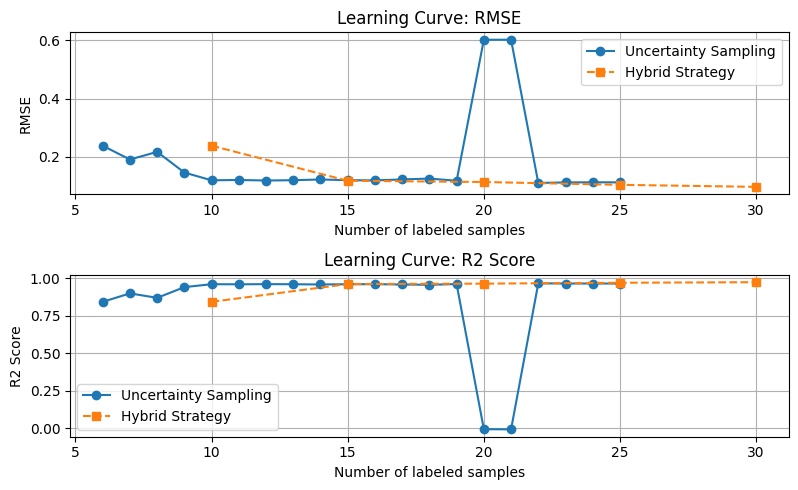

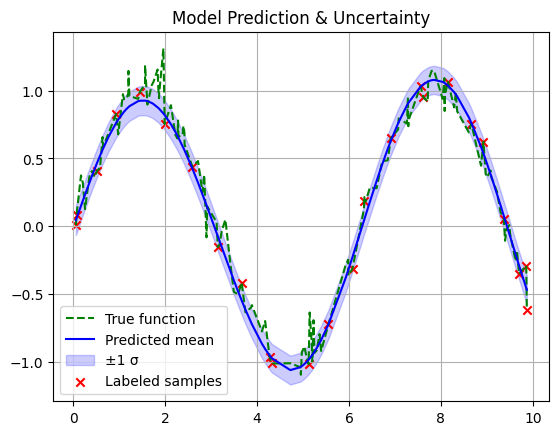

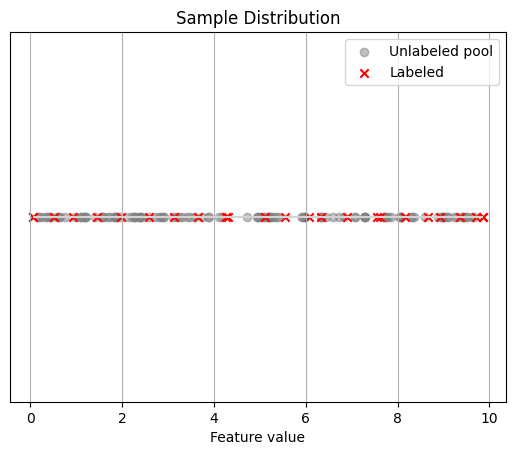

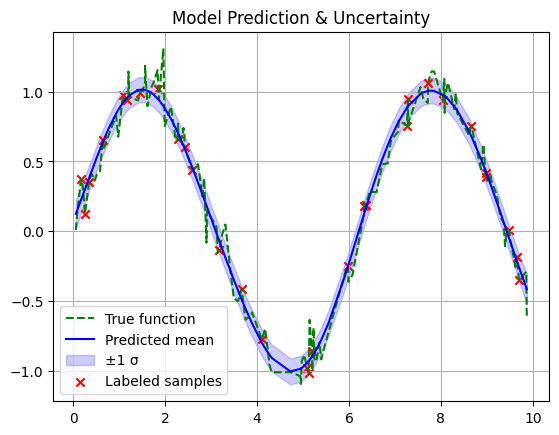

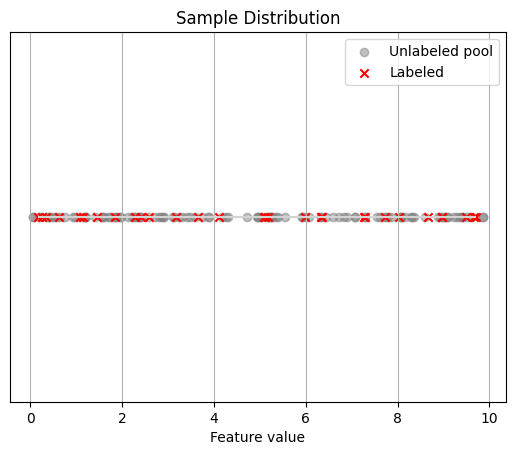

In [21]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random

# 如果要用 XGBoost，请确保已安装：pip install xgboost
try:
    import xgboost as xgb
except ImportError:
    xgb = None

# =========================
# 1. 数据处理模块
# =========================

def load_data(source=None, target_col=None, test_size=0.25, random_state=0):
    """
    通用数据加载函数，参见上节说明。
    返回：X_train(initial empty), y_train(empty), X_pool, y_pool, X_test, y_test
    """
    if source is None:
        rng = np.random.RandomState(random_state)
        X = rng.uniform(0, 10, size=(200, 1))
        y = np.sin(X).ravel() + 0.1 * rng.randn(X.shape[0])
        sort_idx = np.argsort(X[:, 0])
        X, y = X[sort_idx], y[sort_idx]
    elif isinstance(source, str):
        src_lower = source.lower()
        if src_lower in ('boston', 'boston housing'):
            data = datasets.load_boston()
            X, y = data.data, data.target
        elif src_lower == 'diabetes':
            data = datasets.load_diabetes()
            X, y = data.data, data.target
        elif src_lower in ('california', 'california housing'):
            data = datasets.fetch_california_housing()
            X, y = data.data, data.target
        else:
            df = pd.read_csv(source)
            if target_col and target_col in df.columns:
                y = df[target_col].values
                X = df.drop(columns=[target_col]).values
            else:
                y = df.iloc[:, -1].values
                X = df.iloc[:, :-1].values
    elif isinstance(source, pd.DataFrame):
        df = source.copy()
        if target_col and target_col in df.columns:
            y = df[target_col].values
            X = df.drop(columns=[target_col]).values
        else:
            y = df.iloc[:, -1].values
            X = df.iloc[:, :-1].values
    else:
        raise ValueError("Unsupported data source type")
    # 初始 X_train,y_train 置空，交给控制器赋值
    X_train = np.empty((0, X.shape[1]))
    y_train = np.array([])
    X_pool, X_test, y_pool, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, y_train, X_pool, y_pool, X_test, y_test

# =========================
# 2. 模型模块
# =========================

class BaseModel:
    """模型基类，定义接口。"""
    def train(self, X, y):
        raise NotImplementedError
    def predict(self, X):
        raise NotImplementedError
    def predict_with_uncertainty(self, X):
        """返回 (y_mean, y_std)。不支持时可返回 (y_pred, zeros)。"""
        raise NotImplementedError

class GPModel(BaseModel):
    def __init__(self):
        kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
    def train(self, X, y):
        if len(y) == 0:
            return
        self.gp.fit(X, y)
    def predict(self, X):
        return self.gp.predict(X)
    def predict_with_uncertainty(self, X):
        y_mean, y_std = self.gp.predict(X, return_std=True)
        return y_mean, y_std

class XGBModel(BaseModel):
    def __init__(self, n_models=5, **xgb_params):
        if xgb is None:
            raise ImportError("XGBoost library not installed.")
        self.n_models = n_models
        self.models = []
        default_params = {
            'max_depth': 3,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'use_label_encoder': False,
            'eval_metric': 'rmse'
        }
        default_params.update(xgb_params)
        self.xgb_params = default_params

    def train(self, X, y):
        self.models = []
        if len(y) == 0:
            return
        for i in range(self.n_models):
            model = xgb.XGBRegressor(**self.xgb_params, random_state=42 + i)
            model.fit(X, y)
            self.models.append(model)

    def predict(self, X):
        if not self.models:
            return np.zeros(X.shape[0])
        preds = [m.predict(X) for m in self.models]
        preds = np.vstack(preds)
        return np.mean(preds, axis=0)

    def predict_with_uncertainty(self, X):
        if not self.models:
            return np.zeros(X.shape[0]), np.zeros(X.shape[0])
        preds = [m.predict(X) for m in self.models]
        preds = np.vstack(preds)
        mean_pred = np.mean(preds, axis=0)
        std_pred = np.std(preds, axis=0)
        return mean_pred, std_pred

# =========================
# 3. 策略模块
# =========================

class StrategyBase:
    """策略基类，定义select接口。"""
    def select(self, model: BaseModel, X_pool: np.ndarray, y_pool: np.ndarray, batch_size: int):
        raise NotImplementedError

class UncertaintySampling(StrategyBase):
    def select(self, model: BaseModel, X_pool, y_pool, batch_size=1):
        if X_pool.shape[0] == 0:
            return []
        _, std = model.predict_with_uncertainty(X_pool)
        idx = np.argsort(std)
        selected_indices = idx[-batch_size:][::-1]
        return selected_indices.tolist()

class UncertaintyDensitySampling(StrategyBase):
    def __init__(self, k_neighbors=5):
        self.k = k_neighbors

    def _compute_density_scores(self, X_pool):
        N = X_pool.shape[0]
        if N == 0:
            return np.array([])
        # 计算两两距离
        dists = np.linalg.norm(X_pool[:, None, :] - X_pool[None, :, :], axis=2)
        np.fill_diagonal(dists, np.inf)
        k = min(self.k, N - 1)
        nearest_dists = np.partition(dists, kth=k, axis=1)[:, :k]
        avg_dists = nearest_dists.mean(axis=1)
        density_scores = 1.0 / (avg_dists + 1e-8)
        density_scores = (density_scores - density_scores.min()) / (density_scores.max() - density_scores.min() + 1e-8)
        return density_scores

    def select(self, model: BaseModel, X_pool, y_pool, batch_size=1):
        if X_pool.shape[0] == 0:
            return []
        _, std = model.predict_with_uncertainty(X_pool)
        density_scores = self._compute_density_scores(X_pool)
        uncert_scores = (std - std.min()) / (std.max() - std.min() + 1e-8)
        combined_scores = uncert_scores * density_scores
        idx = np.argsort(combined_scores)
        selected_indices = idx[-batch_size:][::-1]
        return selected_indices.tolist()

class DiversitySampling(StrategyBase):
    def __init__(self, mode='farthest'):
        assert mode in ('farthest', 'cluster')
        self.mode = mode

    def select(self, model, X_pool, y_pool, batch_size=1):
        n_pool = X_pool.shape[0]
        if n_pool == 0 or batch_size <= 0:
            return []
        bs = min(batch_size, n_pool)
        if self.mode == 'farthest':
            if bs == 1:
                center = np.mean(X_pool, axis=0)
                dists = np.linalg.norm(X_pool - center, axis=1)
                return [int(np.argmax(dists))]
            selected_idx = []
            center0 = np.mean(X_pool, axis=0)
            first_idx = int(np.argmax(np.linalg.norm(X_pool - center0, axis=1)))
            selected_idx.append(first_idx)
            dist_to_sel = np.linalg.norm(X_pool - X_pool[first_idx], axis=1)
            for _ in range(bs - 1):
                for j in selected_idx:
                    dist_to_sel[j] = 0
                next_idx = int(np.argmax(dist_to_sel))
                selected_idx.append(next_idx)
                new_d = np.linalg.norm(X_pool - X_pool[next_idx], axis=1)
                dist_to_sel = np.minimum(dist_to_sel, new_d)
            return selected_idx
        else:
            k = bs
            kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
            labels = kmeans.fit_predict(X_pool)
            centers = kmeans.cluster_centers_
            selected_idx = []
            for i in range(k):
                cluster_idx = np.where(labels == i)[0]
                dists = np.linalg.norm(X_pool[cluster_idx] - centers[i], axis=1)
                rep = cluster_idx[np.argmin(dists)]
                selected_idx.append(int(rep))
            return selected_idx

class HybridSampling(StrategyBase):
    def __init__(self, candidacy_factor=5):
        self.candidacy_factor = candidacy_factor
        self.uncert_density = UncertaintyDensitySampling()
        self.diversity = DiversitySampling(mode='cluster')

    def select(self, model, X_pool, y_pool, batch_size=1):
        n_pool = X_pool.shape[0]
        if n_pool == 0:
            return []
        bs = min(batch_size, n_pool)
        if bs == 1:
            return self.uncert_density.select(model, X_pool, y_pool, 1)
        M = min(n_pool, bs * self.candidacy_factor)
        _, std = model.predict_with_uncertainty(X_pool)
        density_scores = self.uncert_density._compute_density_scores(X_pool)
        uncert_scores = (std - std.min()) / (std.max() - std.min() + 1e-8)
        combined = uncert_scores * density_scores
        candidate_idx = np.argsort(combined)[-M:]
        candidate_X = X_pool[candidate_idx]
        if bs >= candidate_X.shape[0]:
            return candidate_idx.tolist()
        # 在候选集中做聚类多样性选择
        kmeans = KMeans(n_clusters=bs, random_state=0, n_init='auto')
        labels = kmeans.fit_predict(candidate_X)
        centers = kmeans.cluster_centers_
        selected_candidates = []
        for i in range(bs):
            clu_idx = np.where(labels == i)[0]
            dists = np.linalg.norm(candidate_X[clu_idx] - centers[i], axis=1)
            rep_local = clu_idx[np.argmin(dists)]
            rep_idx = candidate_idx[rep_local]
            selected_candidates.append(int(rep_idx))
        return selected_candidates

# =========================
# 4. 主动学习控制器模块（已添加R²记录）
# =========================

class ActiveLearningController:
    def __init__(self, model: BaseModel, strategy: StrategyBase, batch_size:int=1):
        self.model = model
        self.strategy = strategy
        self.batch_size = batch_size
        self.X_train = None
        self.y_train = None
        self.X_pool = None
        self.y_pool = None
        # 这里history记录为列表，每项为 (labeled_count, rmse, r2)
        self.history = []

    def initialize_data(self, X_train, y_train, X_pool, y_pool):
        self.X_train = X_train.copy()
        self.y_train = y_train.copy()
        self.X_pool = X_pool.copy()
        self.y_pool = y_pool.copy()

    def run(self, n_iterations:int=None, n_total:int=None, X_test=None, y_test=None):
        if self.X_pool is None or self.X_train is None:
            raise RuntimeError("Data not initialized. Call initialize_data first.")
        if n_total is not None:
            target_total = min(n_total, self.X_pool.shape[0] + self.X_train.shape[0])
            current_total = self.X_train.shape[0]
            if self.batch_size > 0:
                n_iterations = int(np.ceil((target_total - current_total) / self.batch_size))
            else:
                n_iterations = 0
        elif n_iterations is None:
            raise ValueError("Either n_iterations or n_total must be provided")
        for it in range(int(n_iterations)):
            # 1. 训练模型
            self.model.train(self.X_train, self.y_train)
            # 2. 选样
            selected_idx = self.strategy.select(self.model, self.X_pool, self.y_pool, batch_size=self.batch_size)
            if len(selected_idx) == 0:
                break
            # 3. Oracle 标注
            new_X = self.X_pool[selected_idx]
            new_y = self.y_pool[selected_idx]
            # 4. 更新已标注集
            if self.X_train.size == 0:
                self.X_train = new_X
                self.y_train = new_y
            else:
                self.X_train = np.vstack([self.X_train, new_X])
                self.y_train = np.concatenate([self.y_train, new_y])
            # 从池中删除已选样本
            for idx in sorted(selected_idx, reverse=True):
                self.X_pool = np.delete(self.X_pool, idx, axis=0)
                self.y_pool = np.delete(self.y_pool, idx, axis=0)
            # 5. 模型评估（计算RMSE和R2）
            if X_test is not None and y_test is not None:
                y_pred_test = self.model.predict(X_test)
                rmse_val = np.sqrt(mean_squared_error(y_test, y_pred_test))
                r2_val = r2_score(y_test, y_pred_test)
            else:
                rmse_val = None
                r2_val = None
            labeled_count = self.X_train.shape[0]
            self.history.append((labeled_count, rmse_val, r2_val))
            print(f"Iteration {it+1}: Labeled {len(selected_idx)} samples, Total labeled = {labeled_count}, RMSE = {rmse_val:.4f}, R2 = {r2_val:.4f}" if rmse_val is not None else "")
            if n_total is not None and labeled_count >= target_total:
                break
        # 最终训练
        self.model.train(self.X_train, self.y_train)
        return self.history

# =========================
# 5. 评估与可视化模块（保留R²绘图示例）
# =========================

def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def compute_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def plot_learning_curve(history):
    """
    绘制学习曲线：左Y轴RMSE，右Y轴R2。X轴为标注样本数量。
    """
    counts = [h[0] for h in history]
    rmses = [h[1] for h in history]
    r2s = [h[2] for h in history]

    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Number of labeled samples")
    ax1.set_ylabel("RMSE", color='tab:red')
    ax1.plot(counts, rmses, 'o-', color='tab:red', label="RMSE")
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel("R2", color='tab:blue')
    ax2.plot(counts, r2s, 's--', color='tab:blue', label="R2")
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title("Learning Curve: RMSE & R2")
    plt.grid(True)
    # 添加图例
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper right")
    plt.show()

def plot_regression_uncertainty(model, X_all, y_all, X_train, y_train):
    plt.figure()
    if X_all.shape[1] == 1:
        idx = np.argsort(X_all[:, 0])
        X_plot = X_all[idx]
        y_true = y_all[idx]
        y_pred, y_std = model.predict_with_uncertainty(X_plot)
        plt.plot(X_plot, y_true, 'g--', label="True function")
        plt.plot(X_plot, y_pred, 'b-', label="Predicted mean")
        plt.fill_between(X_plot.ravel(), y_pred - y_std, y_pred + y_std, color='b', alpha=0.2, label="±1 σ")
    else:
        y_pred = model.predict(X_all)
        plt.scatter(y_pred, y_all, alpha=0.5, label="Pred vs True")
        plt.xlabel("Predicted")
        plt.ylabel("True")

    plt.scatter(X_train[:, 0], y_train, c='r', marker='x', label="Labeled samples")
    plt.title("Model Prediction & Uncertainty")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_sample_distribution(X_train, X_pool):
    plt.figure()
    if X_train.shape[1] == 1:
        plt.hlines(0, X_train.min(), X_train.max(), colors='lightgray')
        plt.scatter(X_pool, np.zeros_like(X_pool), marker='o', color='gray', alpha=0.5, label="Unlabeled pool")
        plt.scatter(X_train, np.zeros_like(X_train), marker='x', color='red', label="Labeled")
        plt.xlabel("Feature value")
        plt.yticks([])
    else:
        plt.scatter(X_pool[:, 0], X_pool[:, 1], color='gray', alpha=0.5, label="Unlabeled pool")
        plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', color='red', label="Labeled")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
    plt.title("Sample Distribution")
    plt.legend()
    plt.grid(True)
    plt.show()

# =========================
# 6. 运行示例（带R2输出）
# =========================

# 准备数据集（合成 sin 函数）
X_train, y_train, X_pool, y_pool, X_test, y_test = load_data(
    source=None, test_size=0.3, random_state=42
)

# 尝试策略：不确定性采样与混合策略
strategy_uncert = UncertaintySampling()
strategy_hybrid = HybridSampling(candidacy_factor=5)

# 从未标注池中随机挑选 init_size = 5 个做为初始标记
init_size = 5
init_indices = np.random.choice(np.arange(X_pool.shape[0]), size=init_size, replace=False)
X_init = X_pool[init_indices]
y_init = y_pool[init_indices]
# 移除已选样本
X_pool_remaining = np.delete(X_pool, init_indices, axis=0)
y_pool_remaining = np.delete(y_pool, init_indices, axis=0)

# 1) 策略1：纯不确定性采样（batch_size=1，最多再选20轮）
al_controller1 = ActiveLearningController(model=GPModel(), strategy=strategy_uncert, batch_size=1)
al_controller1.initialize_data(X_init, y_init, X_pool_remaining, y_pool_remaining)
history1 = al_controller1.run(n_iterations=20, X_test=X_test, y_test=y_test)
print("Final metrics (Uncertainty Sampling):")
print(f"  Labeled samples: {history1[-1][0]}, RMSE = {history1[-1][1]:.4f}, R2 = {history1[-1][2]:.4f}")

# 2) 策略2：混合策略 (不确定性×密度 + 多样性)，batch_size=5，共选5轮（共25点）
al_controller2 = ActiveLearningController(model=GPModel(), strategy=strategy_hybrid, batch_size=5)
al_controller2.initialize_data(X_init, y_init, X_pool_remaining, y_pool_remaining)
history2 = al_controller2.run(n_iterations=5, X_test=X_test, y_test=y_test)
print("Final metrics (Hybrid Strategy):")
print(f"  Labeled samples: {history2[-1][0]}, RMSE = {history2[-1][1]:.4f}, R2 = {history2[-1][2]:.4f}")

# 绘制学习曲线（RMSE & R2 对比）
plt.figure(figsize=(8,5))
counts1 = [h[0] for h in history1]
rmses1  = [h[1] for h in history1]
r2s1    = [h[2] for h in history1]
counts2 = [h[0] for h in history2]
rmses2  = [h[1] for h in history2]
r2s2    = [h[2] for h in history2]

# RMSE 曲线
plt.subplot(2,1,1)
plt.plot(counts1, rmses1, 'o-', label="Uncertainty Sampling")
plt.plot(counts2, rmses2, 's--', label="Hybrid Strategy")
plt.xlabel("Number of labeled samples")
plt.ylabel("RMSE")
plt.title("Learning Curve: RMSE")
plt.legend()
plt.grid(True)

# R2 曲线
plt.subplot(2,1,2)
plt.plot(counts1, r2s1, 'o-', label="Uncertainty Sampling")
plt.plot(counts2, r2s2, 's--', label="Hybrid Strategy")
plt.xlabel("Number of labeled samples")
plt.ylabel("R2 Score")
plt.title("Learning Curve: R2 Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 可视化最终模型预测与不确定性（策略1）
model_trained1 = al_controller1.model
X_all1 = np.vstack([al_controller1.X_train, al_controller1.X_pool])
y_all1 = np.concatenate([al_controller1.y_train, al_controller1.y_pool])
plot_regression_uncertainty(model_trained1, X_all1, y_all1, al_controller1.X_train, al_controller1.y_train)
plot_sample_distribution(al_controller1.X_train, al_controller1.X_pool)

# 可视化最终模型预测与不确定性（策略2）
model_trained2 = al_controller2.model
X_all2 = np.vstack([al_controller2.X_train, al_controller2.X_pool])
y_all2 = np.concatenate([al_controller2.y_train, al_controller2.y_pool])
plot_regression_uncertainty(model_trained2, X_all2, y_all2, al_controller2.X_train, al_controller2.y_train)
plot_sample_distribution(al_controller2.X_train, al_controller2.X_pool)
